# The zfit package

Currently, the functionality of the zfit package is two-fold: design a high-level API to manage model building, fitting and generation, and implement this API using the `tensorflow` backend.

The final goal is to be able to, given a PDF model `pdf`, a dataset `data`, and a list of `params` to minimize, perform minimization tasks such as

```python
from zfit.minimize import Minuit

nll = zfit.unbinned_nll(pdf, data, norm_range=(-10, 10))
minimizer = Minuit()
minimizer.minimize(nll, params)
minimizer.hesse(params)
minimizer.error(params)
result = minimizer.get_state()
```

and generation in a very simple way

```python
sample = pdf.sample(n_draws=int(1e7), limits=(-10, 10))
```

## API

The main concepts in the API are
  - Parameters
  - PDFs (for the time being, let's consider scalar functions as unnormalized PDFs)
  - Minimizers

In the following, we informally outline the basics of each of these objects, but we will not go into some of the more nitty-gritty API details.


### Parameters

Parameters are named quantities to be optimized in the minimization problems we are trying to solve.
Classes implementing parameters contain the value of the parameter, its limits, whether it's fixed or not, and eventually symmetric and asymmetric errors.


A *Parameter* initialization **MUST** contain its name and its initial value, and **MAY** include its lower and upper limits.

One can access the parameter information through the following properties (names are self explanatory):
  - Values are `init_value` are `fitted_value`.
  - Name is accessed through `name`.
  - Errors are `error`, `upper_error` and `lower_error`, and raise an error if one tries to access them without having performed a minimization first.

Additionally, the parameter can be fixed/unfixed setting the `floating` flag to either True or False.



### PDFs

PDF objects are normalized distributions, typically as a function of several parameters.
A very important concept is the *normalization range*, which is mandatory in most operations involving PDFs.

*Note*: details on how to compose and create your own PDFs, implement integrals, etc, belong to the implementation and will be discussed later.

PDF objects **MUST** be initialized giving their named parameters, and **MAY** also have a name. For example:

```python
gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, name="My Gaussian")
```

The main methods of the PDF are then

- Getting the probability through the `probs` method, which **MUST** be called with a data array `x` and a normalization range `norm_range` as inputs. For example:

    ```
    # Get the probabilities of some random generated events
    probs = gauss.prob(x=np.random.random(10), norm_range=(-30., 30))
    ```
- there **MUST** be the option to *temporarely* set the norm_range of a pdf with a contextmanager.**(ALBERT: mention it? ok?)**

    ```python
    with pdf.temp_norm_range((1, 5)):
        pdf.prob(data)  # norm_range is now set
     ```

- Getting the value of its integral in some given `limits`. While the `norm_range` is also mandatory here, it may be requested that this integral is calculated over the unnormalized PDF by setting it to `False`:

    ```python
    # Calculate the integral between -5 and 3 over the PDF normalized between -30 and 30
    integral_norm = gauss.integrate(limits=(-5, 3), norm_range=(-30., 30))
    # Calculate the unnormalized integral
    integral_unnorm = gauss.integrate(limits=(-5, 3), norm_range=False)
    ```

- Sampling from the PDF is done through the `sample` method, which **MUST** include the number of events `n_draws` as well as the limits from which to draw (`limits`):

    ```python
    # Draw 1000 samples within (-10, 10)
    sample = gauss.sample(n_draws=1000, limits=(-10, 10))
    ```

Additionally, extended PDFs, which will result in anything using a `norm_range` to not return the probability but the number probability (the function will be normalized to this yield instead of 1 inside the `norm_range`), can be created through the `set_yield` method, which **MUST** get a parameter as input:

```python
yield1 = Parameter("yield1", 100, 0, 1000)
gauss.set_yield(yield1)
# This integral yields approx 100
integral_extended = gauss.integrate(limits=(-10, 10), norm_range=(-10, 10))
```

The `is_extended` property can be then used to check whether a PDF is extended or not.

Loss functions can then be build using `pdf.prob`, following a common interface, in which the model, the dataset and the normalization range **MUST** be given, and where parameter constraints in form of a dictionary `{param: constraint}` **MAY** be given.
As an example for unbinned NLL (but it's the same for binned NLL, $\chi^2$, etc), one would write

```python
my_loss = zfit.unbinned_nll(gauss,
                            data,
                            norm_range=(-10, 10),
                            constraints={})
```

### Minimizers

Minimizer objects are key to provide a coherent fitting API.
They are tied to a loss function and they keep an internal state that can be queried at any moment.

In their initialization, the loss function **MUST** be given. Additionally, the `params` to minimize, the `tolerance`, its `name`, as well as any other arguments needed to configure a particular algorithm **MAY** be given.

The API **REQUIRES** to implement the following methods:
- `minimize(params)`, which returns an `int` with the status.
- `step(params)`, which performs only one step of the minimization procedure. If not applicable, this returns `NotImplementedError`.
- `hesse(params)`, which calculates the Hessian.
- `error(params)`, which calculates the two-sided error. This typically complicated function can be configured with `set_error_options`. Additionally, several methods for calculating this error can be implemented in a given minimizer, and the `set_error_method` method can be used to set the one called by `error`.
- `get_state(copy=True)`, which returns the internal state of the minimizer, *ie*, the parameters, their errors, etc. The optional `copy` parameters controls whether a copy of the internal state (which would be the equivalent of a fit result) is returned, or just a view (reference) of it.

## Implementation

zfit implements the above API in pure python based on the `tensorflow` framework.

Feature-wise, it adds the capability of building complex models and implementing your own PDFs, some useful functions to make its usage easy, and the possibility of running in a non-eager, advanced mode that allows to take advantage of `tensorflow` graphs.

In addition, it aims to implement a large library of distributions wrapping `tensorflow.distributions` plus the addition of specific HEP ones (not only normalized distributions, but also functions such as spin factors or Blatt-Weisskopf barrier factors), and a complete set of minimizers (currently Minuit, `scipy.optimize` and `tensorflow` optimizers).

As a general idea, context managers will be also implemented wherever there are repetitive parameters to be used (for example, setting normalization ranges) to allow for cleaner code.


Now we'll walk through some simple examples to showcase how zfit is implemented and how to use it in a practical way.

*Note*: We will run in advanced mode (that is, no eager execution, and thus DAG all `tensorflow` objects are DAGs) to illustrate how `tensorflow` is leveraged behind the scenes.
When running in "normal" mode, all these complications (such as the use of sessions and delayed execution) will not be there, thus resulting in simpler code. A context manager will be provided to switch to non-eager execution on the fly.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import zfit

print("TensorFlow version:", tf.__version__)
print("Executing eagerly:", tf.executing_eagerly())

/home/jonas/Documents/physics/software/zfit_project/zfit_repo/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/home/jonas/anaconda3/envs/zfit38/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0-rc2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFl

TensorFlow version: 2.5.0-rc2
Executing eagerly: True


To start off, let's create a few datasets to play with (*note*: no data helpers have been implemented yet, so it's necessary to use tensorflow directly).

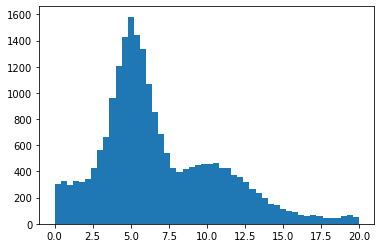

In [2]:
gauss_at_five = np.random.normal(5.1, 1.2, size=10000)
gauss_at_ten = np.random.normal(10.4, 2.3, size=5000)
exp = np.random.exponential(10, size=8000)
_ = plt.hist(np.concatenate([exp,gauss_at_five,gauss_at_ten]),
             bins=50,
             range=(0, 20))

In [3]:
ds_gauss_at_five = tf.convert_to_tensor(gauss_at_five)
ds_gauss_at_ten = tf.convert_to_tensor(gauss_at_ten)
ds_exp = tf.convert_to_tensor(exp)

Now we can try to fit one of the Gaussians.
To do that, we need to create the parameters, instantiate a PDF and run the fitting procedure.

In [4]:
# This shortcut function will be available in zfit, but here
# we use the core one to highlight the use of tensorflow graphs
def api_unbinned_nll(pdf, data, norm_range):
    return zfit.core.loss.unbinned_nll(pdf.prob(data, norm_range=norm_range))

mu1 = zfit.Parameter("mu", 5.0, 0., 10)
sigma1 = zfit.Parameter("sigma", 1, 0.1, 5.)
gauss1 = zfit.pdf.Gauss(mu=mu1, sigma=sigma1)

nll1 = api_unbinned_nll(gauss1, ds_gauss_at_five, (0, 20))

AttributeError: module 'zfit' has no attribute 'FitParameter'

In [ ]:
from zfit.minimize import Minuit

minimizer = Minuit(nll1)
# Prepare tensorflow, this will be removed in the future


